#### Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

#### Reading Dataset

We have five different youtube files that we need to concatenate into a single file.

In [2]:
files = glob.glob('youtube-dataset/youtube-dataset\\*.csv') # To get all files in csv format

In [3]:
files  # List of the path names

['youtube-dataset/youtube-dataset\\Youtube01.csv',
 'youtube-dataset/youtube-dataset\\Youtube02.csv',
 'youtube-dataset/youtube-dataset\\Youtube03.csv',
 'youtube-dataset/youtube-dataset\\Youtube04.csv',
 'youtube-dataset/youtube-dataset\\Youtube05.csv']

In [4]:
datasets = []
for i in files:  # To pick the file names one by one
    datasets.append(pd.read_csv(i).drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis = 1))
    # Reading from all files and dropping the columns that we don't need from each

datasets[0].head()   # 0 index is the first csv file

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,watch?v=vtaRGgvGtWQ Check this out .﻿,1
4,"Hey, check out my new website!! This site is a...",1


In [5]:
type(datasets), len(datasets)

(list, 5)

In [6]:
# Let's combine all csv files into a one dataframe

# First argument is the pandas object we want to concatenate
# Second argument is to Concatenate along the horizontal axis
# Third argument is to drop the original indexing and enumerate from 0 to n-1
df = pd.concat(datasets, axis = 0, ignore_index=True)
df.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,watch?v=vtaRGgvGtWQ Check this out .﻿,1
4,"Hey, check out my new website!! This site is a...",1


In [7]:
type(df), df.shape

(pandas.core.frame.DataFrame, (1955, 2))

#### Checking for Nulls

In [8]:
df.isna().sum()  # There are no nulls

CONTENT    0
CLASS      0
dtype: int64

#### Checking frequency of target class

In [9]:
df['CLASS'].value_counts()  # 1 is spam and 0 is ham

CLASS
1    1004
0     951
Name: count, dtype: int64

For the Naive bayes to work optimally, dataset needs to be balanced. Our dataset has roughly the same number of records from each class.

#### Understanding CountVectorizer

To process and understand text data in machine learning tasks like spam detection, we often need to convert the raw text into numerical features that models can work with. One of the simplest and most commonly used tools for this is CountVectorizer from the sklearn.feature_extraction.text module.

CountVectorizer converts a collection of text documents into a matrix of token (word) counts. This process is often referred to as bag-of-words representation. It performs the following steps:
* Tokenization: Splits each text (document) into individual words (tokens).
* Vocabulary Building: Collects all unique words across the corpus to create a vocabulary.
* Encoding: For each document, counts the frequency of each word in the vocabulary.

This method does not consider word order, grammar, or context - just the presence and frequency of each word in each document.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
text_example = ['She is learning something new']

vectorizer_sample = CountVectorizer()
vectorizer_sample.fit(text_example)
vectorizer_sample.transform(text_example).toarray() # As it creates sparse matrix

array([[1, 1, 1, 1, 1]], dtype=int64)

In [12]:
vectorizer_sample.get_feature_names_out()

array(['is', 'learning', 'new', 'she', 'something'], dtype=object)

This states that each of these words appears only once. Let's try with another sentence.

In [13]:
text_example2 = ['He is learning to drive']
vectorizer_sample.transform(text_example2).toarray()

array([[1, 1, 0, 0, 0]], dtype=int64)

In [14]:
vectorizer_sample.get_feature_names_out()

array(['is', 'learning', 'new', 'she', 'something'], dtype=object)

There is 1 for the words that the vectorizer has seen on fitting - is and learning - but the rest of the words are not seen by the vectorizer so its putting 0 in those places.

In [15]:
# Now let's use fit_transform with two sentences

text_example = ['She is learning something new', 'He is learning to drive']
vectorizer_sample = CountVectorizer()
vectorizer_sample.fit_transform(text_example).toarray()

array([[0, 0, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0, 0, 0, 1]], dtype=int64)

In [16]:
vectorizer_sample.get_feature_names_out()

array(['drive', 'he', 'is', 'learning', 'new', 'she', 'something', 'to'],
      dtype=object)

This shows the vocabulary list has now expanded. Each row in the matrix corresponds to a sentence (or document), and each column corresponds to a word from the vocabulary. The numbers in the matrix indicate how many times each word appeared in each sentence.

#### Splitting the dataset

Let's split the dataset into train and test set first

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = df['CONTENT']
y = df['CLASS']

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                   stratify= y)  
# Stratify is done so that equal portion of the target enters training and testing set

In [19]:
x_train.shape, x_test.shape

((1759,), (196,))

In [20]:
y_train.value_counts(normalize=True)  # Almost equally spread

CLASS
1    0.51336
0    0.48664
Name: proportion, dtype: float64

In [21]:
y_test.value_counts(normalize=True)  # Almost equally spread

CLASS
1    0.515306
0    0.484694
Name: proportion, dtype: float64

#### Tokenizing the comments from our dataset using Vectorizer

In [22]:
# Now getting started with vectorizer

vectorizer = CountVectorizer()
x_train_transformed = vectorizer.fit_transform(x_train)
x_test_transformed = vectorizer.transform(x_test)
x_train_transformed.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
x_train_transformed.shape  # There are 1759 rows and 4210 columns which are actually the different words present in the vocabulary created


(1759, 4210)

In [24]:
x_test_transformed.shape

(196, 4210)

#### Applying dataset to Model

In [25]:
from sklearn.naive_bayes import MultinomialNB
# Since our dataset is textual and the classes are roughly balanced

clf = MultinomialNB()
clf.fit(x_train_transformed, y_train)

MultinomialNB()

In [26]:
clf.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

* **alpha (1.0)**: This is the smoothing parameter (Laplace smoothing). It prevents zero probabilities for words not seen in training data. A value of 1.0 means standard Laplace smoothing is applied.

* **class\_prior (None)**: This indicates no manual prior probabilities for classes are provided. The priors will be learned from the training data.

* **fit\_prior (True)**: This means the model will estimate class prior probabilities from the training data rather than assuming them to be uniform.

* **force\_alpha (True)**: Ensures that smoothing (alpha) is applied even when alpha is set to zero, maintaining numerical stability.

These parameters control how the Multinomial Naive Bayes model learns and applies probabilities.


In [27]:
np.exp(clf.class_log_prior_)

array([0.48664014, 0.51335986])

Here we are taking the log prior probabilities of each class from a trained Naive Bayes classifier (clf.class_log_prior_), and applying the exponential function to convert them back from log space to regular probability space.

This tells us the model has learned the following class prior probabilities:
* Probability of class 0 (e.g., "ham") = 48.66%
* Probability of class 1 (e.g., "spam") = 51.34%

These priors are computed from the training data, assuming fit_prior=True, and they reflect the class distribution observed in the training set.

In [28]:
predictions = clf.predict(x_test_transformed)

#### Evaluating the model

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
print(confusion_matrix(predictions, y_test))

[[82  6]
 [13 95]]


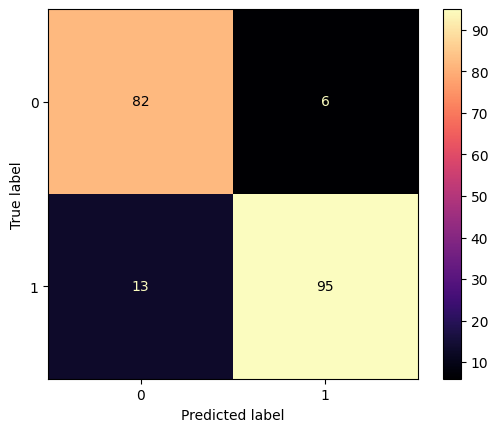

In [31]:
ConfusionMatrixDisplay.from_predictions(
    predictions, y_test,
    labels = clf.classes_,
    cmap = 'magma'
);

* **82**: **True Negatives (TN)** - actual class is 0, predicted as 0
* **6**: **False Positives (FP)** - actual class is 0, predicted as 1 (These are also called **Type 1 errors**).
* **13**: **False Negatives (FN)** - actual class is 1, predicted as 0 (These are also called **Type 2 errors**).
* **95**: **True Positives (TP)** - actual class is 1, predicted as 1

Thus, TP is 95 which are correctly predicted class 1. TN is 82 which are correctly predicted class 0. FP is 6 where predicted class 1 but actually class 0. FN is 13 where predicted class 0 but actually class 1. So, the model made **177 correct predictions** (82 + 95) and **19 incorrect ones** (6 + 13).


Let's try with different other evaluation metrics - 

In [32]:
from sklearn.metrics import classification_report

In [33]:
print(classification_report(predictions, y_test,
                           target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.86      0.93      0.90        88
        Spam       0.94      0.88      0.91       108

    accuracy                           0.90       196
   macro avg       0.90      0.91      0.90       196
weighted avg       0.91      0.90      0.90       196



#### Creating probability distribution figure

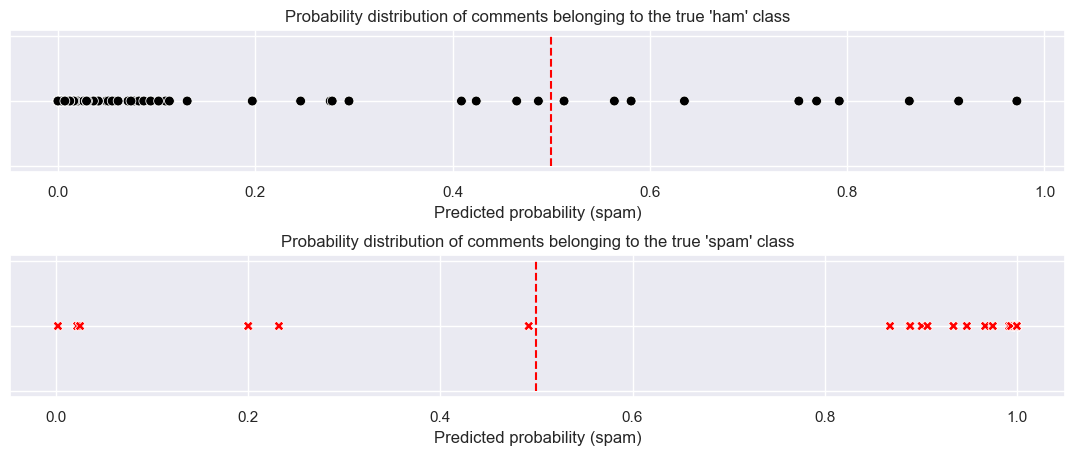

In [34]:
spam_proba = clf.predict_proba(x_test_transformed).round(3)[:,1];

df_scatter = pd.DataFrame()

df_scatter['True class'] = y_test
df_scatter['Predicted class'] = predictions
df_scatter['Predicted probability (spam)'] = spam_proba

df_scatter = df_scatter.reset_index(drop = True)

palette_0 = sns.color_palette(['#000000'])
palette_1 = sns.color_palette(['#FF0000'])

df_scatter_0 = df_scatter[df_scatter['True class'] == 0].reset_index(drop = True)
df_scatter_1 = df_scatter[df_scatter['True class'] == 1].reset_index(drop = True)

sns.set()

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,5))
fig.tight_layout(pad = 3)

sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_0.shape[0]), 
                data = df_scatter_0,
                hue = 'True class', 
                s = 50,
                markers = ['o'],
                palette = palette_0,
                style = 'True class',
                legend = False, 
                ax = ax1).set(yticklabels=[])

ax1.set_title('Probability distribution of comments belonging to the true \'ham\' class')
ax1.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');


sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_1.shape[0]), 
                hue = 'True class', 
                data = df_scatter_1,
                s = 50,
                palette = palette_1,
                markers = ['X'],
                style = 'True class',
                legend = False, 
                ax = ax2).set(yticklabels=[])

ax2.set_title('Probability distribution of comments belonging to the true \'spam\' class')

ax2.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');

#### Optimizing Model

Here we will use -
    
clf = MultinomialNB(class_prior=np.array([0.6, 0.4]))

This line creates a Multinomial Naive Bayes classifier with manually specified class prior probabilities:
* It sets the prior probability for **class 0** to **0.6** (60%)
* It sets the prior probability for **class 1** to **0.4** (40%)

The key difference is that the class prior is explicitly defined by the user instead of being inferred from the training data* which is what happens by default. If `fit_prior=True` and `class_prior=None` (the default behavior), then the classifier automatically calculates the priors from the training data based on the frequency of each class.

By setting `class_prior=np.array([0.6, 0.4])`, we override the learned class distribution and force the model to assume that Class 0 is more likely by prior belief, regardless of the actual distribution in training data.

**This Can Change Results:**

* **Bias Introduction**: If the actual class distribution in the data is different (say, 50-50), then assigning a 60-40 prior introduces bias toward class 0.
* **Prediction Shifts**: During prediction, Bayes' theorem multiplies the likelihood by the prior. A higher prior for class 0 can cause more test samples to be classified as class 0, even if their features slightly favor class 1.
* **Useful in Imbalanced or Domain-Specific Contexts**: This can be intentional and beneficial if you already know from external knowledge that one class is inherently more common or important, even if your training data doesn’t reflect that.

This line adds manual control over class bias in the model, which can significantly alter classification outcomes.


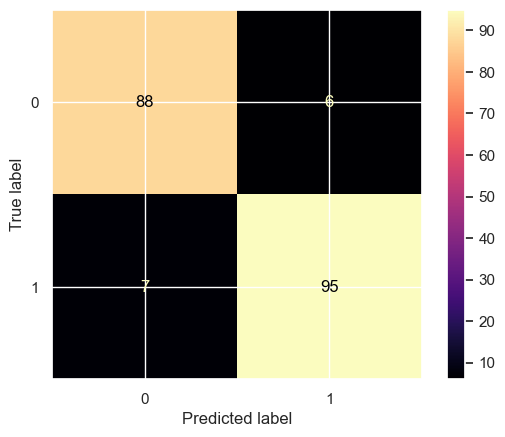

In [35]:
# Let's try using different hyperparameters

clf = MultinomialNB(class_prior= np.array([0.6, 0.4]))
clf.fit(x_train_transformed, y_train)
prediction_new = clf.predict(x_test_transformed)

ConfusionMatrixDisplay.from_predictions(
    prediction_new, y_test,
    labels = clf.classes_,
    cmap = 'magma'
);

Thus, we see more classes are correctly labelled than previous model. 

In [36]:
print(classification_report(prediction_new, y_test,
                           target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.93      0.94      0.93        94
        Spam       0.94      0.93      0.94       102

    accuracy                           0.93       196
   macro avg       0.93      0.93      0.93       196
weighted avg       0.93      0.93      0.93       196



#### Creating probability distribution figure

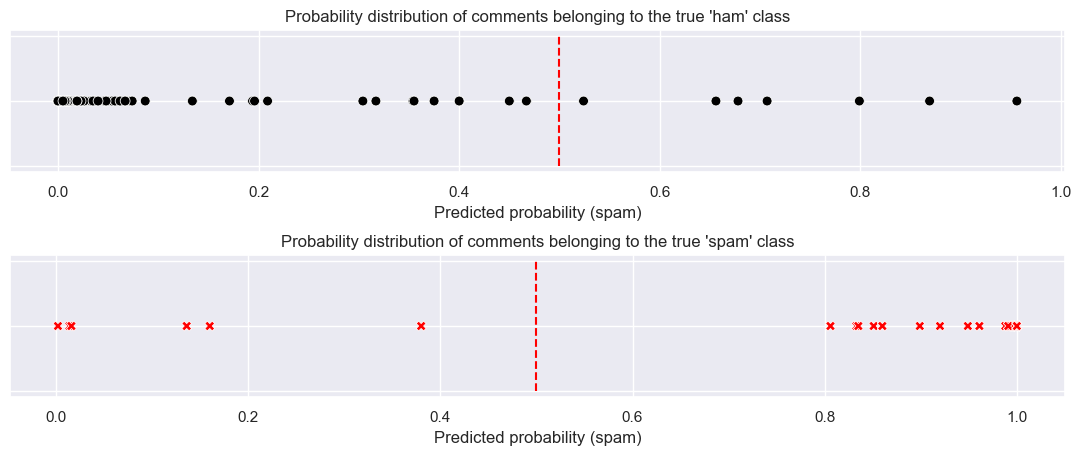

In [37]:
spam_proba = clf.predict_proba(x_test_transformed).round(3)[:,1];

df_scatter = pd.DataFrame()

df_scatter['True class'] = y_test
df_scatter['Predicted class'] = prediction_new
df_scatter['Predicted probability (spam)'] = spam_proba

df_scatter = df_scatter.reset_index(drop = True)

palette_0 = sns.color_palette(['#000000'])
palette_1 = sns.color_palette(['#FF0000'])

df_scatter_0 = df_scatter[df_scatter['True class'] == 0].reset_index(drop = True)
df_scatter_1 = df_scatter[df_scatter['True class'] == 1].reset_index(drop = True)

sns.set()

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,5))
fig.tight_layout(pad = 3)

sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_0.shape[0]), 
                data = df_scatter_0,
                hue = 'True class', 
                s = 50,
                markers = ['o'],
                palette = palette_0,
                style = 'True class',
                legend = False, 
                ax = ax1).set(yticklabels=[])

ax1.set_title('Probability distribution of comments belonging to the true \'ham\' class')
ax1.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');


sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_1.shape[0]), 
                hue = 'True class', 
                data = df_scatter_1,
                s = 50,
                palette = palette_1,
                markers = ['X'],
                style = 'True class',
                legend = False, 
                ax = ax2).set(yticklabels=[])

ax2.set_title('Probability distribution of comments belonging to the true \'spam\' class')

ax2.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');

#### Data Prediction using Unknown Data

In [38]:
predict_data = vectorizer.transform(['This song is amazing!',
                                     'You can win 1m dollars right now, just click here!!!'])

clf.predict(predict_data)

array([0, 1], dtype=int64)

The comments are correctly classified!